# Sophisticated inference with Monte Carlo Tree Search

This notebook demonstrates how you can implement Sophisticated inference with a Monte Carlo tree search algorithm, to mitigate the combinatorial explosion of exploring all branches. 

### Sophisticated inference

In sophisticated inference the choice probability is computed in an iteartive way, using the following recursive relation for expected free energy 

\begin{equation}
\begin{split}
    G(u_\tau| o_{\leq\tau}, u_{<\tau}) &= - \ln p(u_{\tau}|u_{<\tau}) + E_{Q(o_{\tau+1}, s_{\tau+1}|u_{\leq\tau}. o_{<\tau})} \left[ \ln \frac{Q(s_{\tau+1}|u_{\leq\tau}, o_{<\tau})}{P(o_{\tau+1}, s_{\tau+1})} \right] \\ 
    &\:\:\: + E_{Q(o_{\tau+1}|u_{\leq\tau}, o_{\leq\tau}) Q(u_{\tau+1}|u_{< \tau + 1}, o_{\leq\tau+1})}\left[G(u_{\tau + 1}|o_{\leq \tau+1}, u_{<\tau+1} ) \right]\\ 
    Q(u_{\tau}|o_{\leq\tau}, u_{<\tau}) &= \text{softmax}(- G(u_{\tau}|o_{\leq\tau}, u_{<\tau})) \\ 
    G(u_T|o_{\leq T}, u_{< T}) &= - \ln p(u_{T}|u_{< T}) + E_{Q(o_{T+1}, s_{T+1}|u_{\leq T}, o_{< T})} \left[ \ln \frac{Q(s_{T+1}|u_{\leq T}, o_{< T})}{P(o_{T + 1}, s_{T + 1})} \right]
\end{split}
\end{equation}

where we use subscript $<k+1$, and $\leq k$ to denote a sequence of values including the step $k$.

Next we will establish an equivalence between the Bellman equation used in reinforcement learning literature and the recursive form of the expected free energy shown above. The Bellman equation can be expressed as  
\begin{equation}
  V(s) = \text{max}_{a \in A(s)} \left[F(s, a) + \beta E_{p(s^\prime|s, a)}[V(s^\prime)] \right] \equiv \text{max}_{a \in A(s)} Q(a, s)
\end{equation}
where $A(s)$ denotes a set of viable actions in state $s$. Hence, we can map local expected free energy, to Q-values as follows
\begin{equation}
  \begin{split}
    F(u_{\tau}, o_{\tau}) &= \ln p(u_{\tau}|u_{<\tau}) - E_{Q(o_{\tau+1}, s_{\tau+1}|u_{\leq\tau}. o_{<\tau})} \left[ \ln \frac{Q(s_{\tau+1}|u_{\leq\tau}, o_{<\tau})}{P(o_{\tau+1}, s_{\tau+1})} \right] \\ 
    \beta(o_{\tau +1}) &= Q (o_{\tau+1}|u_{\leq\tau}, o_{\leq\tau}) \\
    Q(u_{\tau}, o_{\tau}) &= F(u_{\tau}, o_{\tau}) + \sum_{o_{\tau+1}} \beta(o_{\tau+1}) V(o_{\tau+1}) \\
    p(u_{\tau}|o_{\tau}) &= \text{softmax}(\gamma Q(u_{\tau}, o_{\tau}) ) \\
    V(o_{\tau}) &= \sum_{u_\tau} p(u_{\tau}|o_{\tau}) Q(u_{\tau}, o_{\tau})
  \end{split}
\end{equation}

where we have replaced the 'max' operationa with a softmax parameterised with $\gamma$, and introduced a state dependent discount factor $\beta(o)$. Note that in sophisticated inference, as we describe a partially observable markov decision process (POMDP), one treats outcomes $o_t$ as states.

### Monte-Carlo Tree Search

Tree search is a method for exploring a space of sequential decisions, where nodes represent states or histories (e.g., observations and actions), and edges represent possible actions. Monte Carlo Tree Search (MCTS) is a popular tree search algorithm that builds the tree incrementally using random simulations. It involves four steps: selecting a node to expand using a policy like UCB, expanding the node by adding new children, simulating outcomes via rollouts from the new node, and backpropagating the results to update value estimates and visit counts.

To estimate the choice probability $p(u_t | o_{\leq t}, u_{<t})$, MCTS is run from a root node representing the current history of outcomes and actions. During the search, possible actions $u_t$ are explored, and the number of visits to each action is tracked. After many simulations, the estimated probability of choosing action $u_t$ is given by the normalized visit count:

$$
p(u_t | o_{\leq t}, u_{<t}) \approx \frac{N(u_t)}{\sum_{u'_t} N(u'_t)}.
$$

This provides a sample-based approximation of the decision policy based on simulated future outcomes.

### Discounting and sampling outcomes 

In a scenario where we have multi-modal outcomes, such that the likelihood probability is expressed as

$$ p(o_\tau|s_\tau) = \prod_m p(o_\tau^m|s_\tau), $$

the marginal probability over latent states $s_{tau}$ obtained as 

$$ p(o_\tau|u_{\tau-1}) = \sum_{s_\tau} \prod_m p(o_\tau^m|s_\tau) Q(s_{\tau}|u_{\tau-1})$$

will in general not be factorized over outcome modalities. Hence, to generate samples from this marginal, and consequently compute discount factor for the corresponding sample, one would have to deal with joint distributions over categoricals, which are memory intensive. Instead, here we will define an iterative sampling algorithm. Starting with a sample from the first modality $m=1$ 

\begin{equation}
o^{\prime 1}_\tau \sim p(o_\tau^1|u_{\tau-1})
\end{equation}

we can compute the conditional probability of the next modality $m=2$ and generate a sample as  

\begin{equation}
\begin{split}
     p(o_\tau^2|o_\tau^1=o^{\prime 1}_\tau, u_{\tau-1}) &= \sum_{s_\tau} p(o_\tau^m|s_\tau) w(o^{\prime 1}_\tau, s_{\tau}) Q(s_{\tau}|u_{\tau-1}) \\
     w(o^{\prime 1}_\tau, s_{\tau}) &= \frac{p(o_\tau^1=o^{\prime 1}_\tau|s_\tau)}{p(o_\tau^1=o^{\prime 1}_\tau|u_{\tau-1})} \\
    o^{\prime 2}_\tau &\sim p(o_\tau^2|o_\tau^1=o^{\prime 1}_\tau, u_{\tau-1})
\end{split}
\end{equation}

Hence, for the $m$th modality we can compute the conditional marginal, and generate a sample using the following relation

\begin{equation}
\begin{split}
     p(o_\tau^m|o_\tau^1=o^{\prime 1}_\tau, \ldots, o_\tau^{m-1}=o^{\prime m-1}_\tau, u_{\tau-1}) &= \sum_{s_\tau} p(o_\tau^m|s_\tau) w(o^{\prime 1}_\tau, \ldots, o^{\prime m-1}_\tau, s_{\tau}) Q(s_{\tau}|u_{\tau-1}) \\
     w(o^{\prime 1}_\tau, \ldots, o^{\prime m-1}_\tau, s_{\tau}) &= \frac{p(o_\tau^{m-1}=o^{\prime m-1}_\tau|s_\tau)}{p(o_\tau^{\prime m-1}|o_\tau^1=o^{\prime 1}_\tau, \ldots, o_\tau^{m-2}=o^{\prime m-2}_\tau, u_{\tau-1})} w(o^{\prime 1}_\tau, \ldots, o^{\prime m-2}_\tau, s_{\tau}) \\
    o^{\prime m}_\tau &\sim p(o_\tau^m|o_\tau^1=o^{\prime 1}_\tau, \ldots, o_\tau^{m-1}=o^{\prime m-1}_\tau, u_{\tau-1})
\end{split}
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import jax.numpy as jnp
import jax.tree_util as jtu
import mctx
from jax import random as jr


from pymdp.envs.generalized_tmaze import (
    GeneralizedTMazeEnv, parse_maze, get_maze_matrix, render 
)

from pymdp.envs.rollout import rollout
from pymdp.agent import Agent as AIFAgent
from pymdp.planning.mcts import mcts_policy_search

key = jr.PRNGKey(0)


In [2]:
# make animation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

def animate(images, savefile=None):
    fig, ax = plt.subplots()

    sns.despine(fig, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    frames = []
    for i, img in enumerate(images):
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        frames.append([im])

    ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True,
                                    repeat_delay=1000)

    # To save the animation, use e.g.
    if savefile is not None:
        ani.save(savefile)

    plt.close(ani._fig)

    return ani

### Grid world (generalized TMaze) generative process

In this example we create a simple square environment, where multiple cues are present, and multiple reward pairs. Each cue indicates the location of one of the reward pairs. 

The agent is can move in the grid world using actions up, down, left and right, and observes the current tile it is at. 

The grid world is specified by a matrix using the following labels: 

```
0: Empty space
1: The initial position of the agent
2: Walls
3 + i: Cue for reward i
4 + i: Potential reward location i 1
4 + i: Potential reward location i 2
```

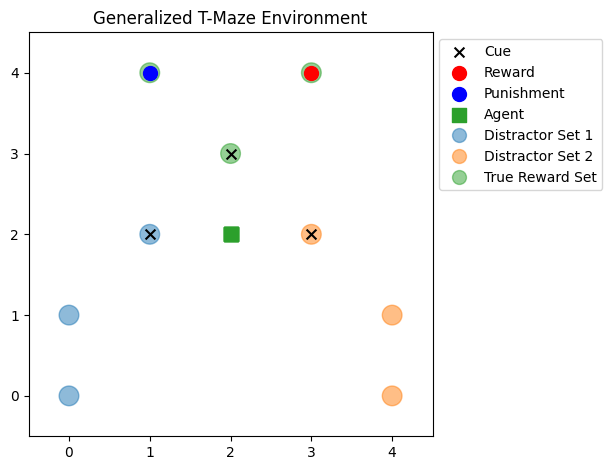

In [3]:
M = get_maze_matrix()
key, subkey = jr.split(key)
env_info_m = parse_maze(M, subkey)
# we simulate 5 agents in parallel
tmaze_env_m = GeneralizedTMazeEnv(env_info_m, batch_size=5)

keys = jr.split(key, num=6)
key = keys[0]
obs, env = tmaze_env_m.reset(keys[1:])
_ = render(env_info_m, env)

#### Create the agent. 

The PyMDPEnv class consists of a params dict that contains the A, B, and D vectors of the environment. We initialize our agent using the same parameters. This means that the agent has full knowledge about the environment transitions, and likelihoods. We initialize the agent with a flat prior, i.e. it does not know where it, or the reward is. Finally, we set the C vector to have a preference only over the rewarding observation of cue-reward pair 1 (i.e. C[-1] = [0, 1, -2]  and zero for all other modalities). 

In [4]:
def make_aif_agent(tmaze_env):
    A = [a.copy() for a in tmaze_env.params["A"]]
    B = [b.copy() for b in tmaze_env.params["B"]]
    A_dependencies = tmaze_env.dependencies["A"]
    B_dependencies = tmaze_env.dependencies["B"]

    # [position], [cue], [reward]
    C = [jnp.zeros(a.shape[:2]) for a in A]

    rewarding_modality = -1

    C[rewarding_modality] = C[rewarding_modality].at[:, 1].set(1.0)
    C[rewarding_modality] = C[rewarding_modality].at[:, 2].set(-2.0)

    D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

    agent = AIFAgent(
        A, B, C, D, 
        E=None,
        pA=None,
        pB=None,
        policy_len=1,
        A_dependencies=A_dependencies, 
        B_dependencies=B_dependencies,
        use_utility=True,
        use_states_info_gain=True,
        sampling_mode='full',
        apply_batch=False,
        learn_A=False,
        learn_B=False
    )

    return agent

### MCTS based policy search

Here we defined the sofisticated active inference monte-carlo tree search policies using the [mctx](https://github.com/google-deepmind/mctx) package for google deep mind. Although other algorithms are provided in mctx package here we will use only Gumbel based planning algorithm intoroduced in [Policy improvement by planning with Gumbel](https://openreview.net/forum?id=bERaNdoegnO).

### Run active inference

In [5]:
timesteps = 6
agent = make_aif_agent(tmaze_env_m)
_, info, _ = rollout(agent, tmaze_env_m, num_timesteps=timesteps, rng_key=key, policy_search=mcts_policy_search(search_algo=mctx.gumbel_muzero_policy, max_depth=4, num_simulations=1024))

When we plot the resulting data, we see all agents prefer the correct cue that is actually yielding reward, and avoid the distracting cues. Depending on the amount of samples though, some agents might still get distracted the first timestep.

In [6]:
images = []
for t in range(timesteps):
    env_state = jtu.tree_map(lambda x: x[t, :], info['env'])
    images.append(np.array(render(env_info_m, env_state, show_img=False)) )

In [7]:
ani = animate(images)

HTML(ani.to_html5_video())